# Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
import STAGATE

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
counts_file = os.path.join('Data/Tutorial4/RNA_counts.tsv')
coor_file = os.path.join('Data/Tutorial4/position.tsv')

In [6]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')
print(counts.shape, coor_df.shape)

(27106, 19527) (19527, 3)


In [7]:
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

In [8]:
coor_df.head()

,x,y
label,,
Spot_1,12555.007833,6307.537859
Spot_2,12623.666667,6297.166667
Spot_3,12589.567164,6302.552239
Spot_4,12642.495050,6307.386139
Spot_5,13003.333333,6307.990991


In [9]:
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()

In [10]:
adata

AnnData object with n_obs × n_vars = 19527 × 27106

In [11]:
coor_df = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obsm["spatial"] = coor_df.to_numpy()
sc.pp.calculate_qc_metrics(adata, inplace=True)

(6002.432692307693, 12486.580128205129, 9908.545833333334, 15086.093055555555)

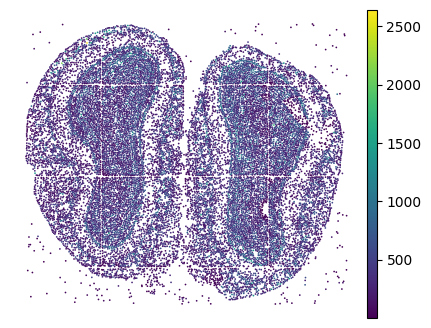

In [12]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [13]:
used_barcode = pd.read_csv(os.path.join('Data/Tutorial4/used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]

In [14]:
adata

View of AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(6005.190789473685, 12428.6600877193, 9986.774763741741, 15062.302776957436)

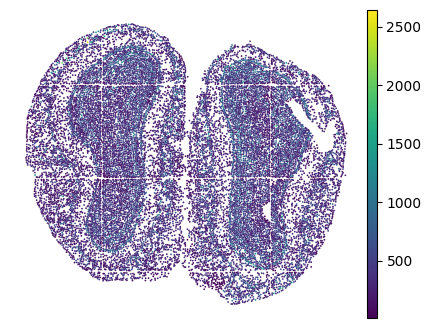

In [15]:
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [16]:
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

After flitering:  (19109, 14376)


In [17]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Constructing the spatial network

------Calculating spatial graph...
The graph contains 144318 edges, 19109 cells.
7.5524 neighbors per cell on average.


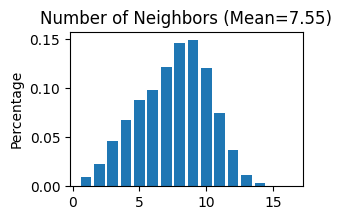

In [18]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=50)
STAGATE.Stats_Spatial_Net(adata)

# Running STAGATE

In [19]:
adata.X = adata.X.astype('float64')

In [20]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (19109, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2023-10-19 16:43:19.854253: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-10-19 16:43:19.872804: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2023-10-19 16:43:19.884363: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5600a73e3530 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-10-19 16:43:19.884395: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-10-19 16:43:19.886538: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-10-19 16:43:20.023478: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5601eff2a1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-19 16:43:20.023543: I tensorflow/compil

In [21]:
adata.obsm['STAGATE']

array([[ 3.1905966 ,  0.34798294, -0.44162226, ..., -1.8414248 ,
        -1.4552822 , -1.8439233 ],
       [ 1.9143368 ,  0.75543904,  0.02253258, ..., -0.9759674 ,
        -2.7668412 , -0.44473922],
       [ 0.6271563 ,  0.97089225, -0.36059892, ..., -2.792172  ,
        -2.582911  , -0.81695986],
       ...,
       [ 0.5711235 ,  0.8385167 , -1.4551241 , ..., -2.280097  ,
        -1.9941497 , -1.5761054 ],
       [ 1.7950581 ,  0.730005  , -0.07855955, ..., -2.0665832 ,
        -1.4972484 , -0.8077336 ],
       [ 1.236402  ,  0.64587295, -2.114214  , ..., -1.9495575 ,
        -1.8514736 , -1.6217015 ]], dtype=float32)

In [22]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [23]:
sc.tl.louvain(adata, resolution=0.8)

(6005.190789473685, 12428.6600877193, 9986.774763741741, 15062.302776957436)

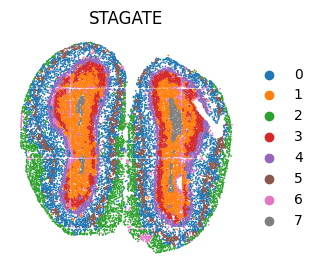

In [24]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False, title='STAGATE')
plt.axis('off')

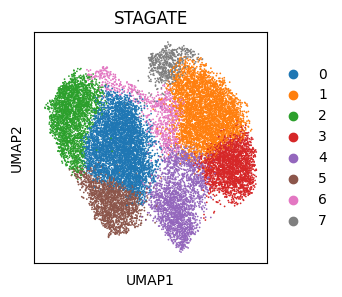

In [25]:
sc.pl.umap(adata, color='louvain', title='STAGATE')

# SCANPY results (for comparison)

In [26]:
sc.pp.pca(adata, n_comps=30)

In [27]:
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.louvain(adata, resolution=0.8)
sc.tl.umap(adata)

(6005.190789473685, 12428.6600877193, 9986.774763741741, 15062.302776957436)

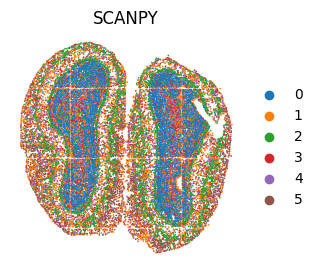

In [28]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False, title='SCANPY')
plt.axis('off')

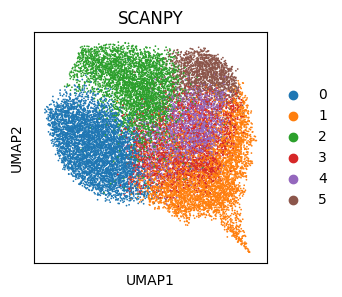

In [29]:
sc.pl.umap(adata, color='louvain', title='SCANPY')